In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

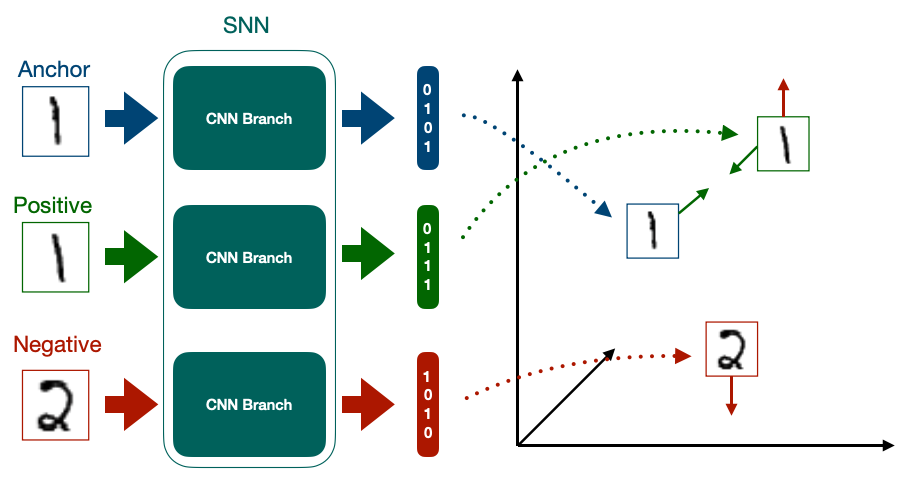

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
Data_dir = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[14]

A_img = io.imread(Data_dir + row['Anchor'])
P_img = io.imread(Data_dir + row['Positive'])
N_img = io.imread(Data_dir + row['Negative'])

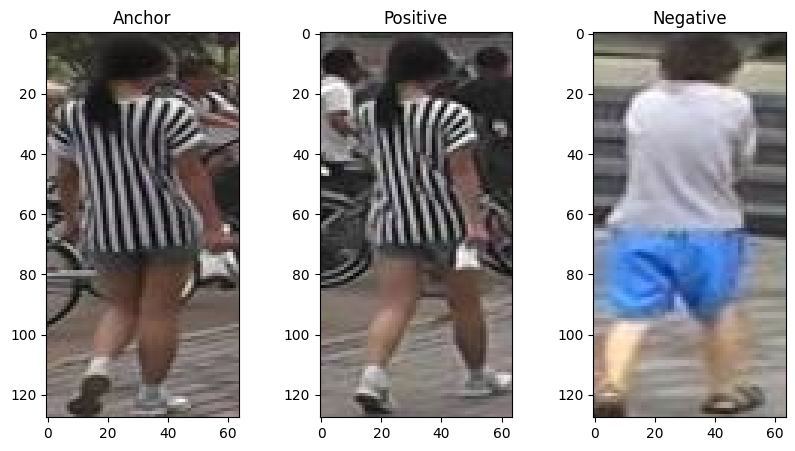

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

plt.show()

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(Data_dir + row['Anchor'])
    P_img = io.imread(Data_dir + row['Positive'])
    N_img = io.imread(Data_dir + row['Negative'])

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Size of train set is {len(trainset)}')
print(f'Size of valid set is {len(validset)}')

Size of train set is 3200
Size of valid set is 800


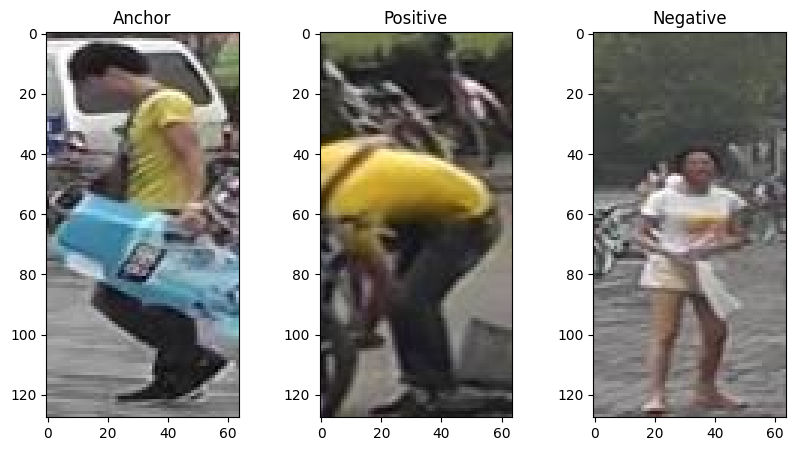

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

      return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('saved weights success')

  print(f'Epochs: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}')


  0%|          | 0/25 [00:00<?, ?it/s]


saved weights success
Epochs: 1 train_loss: 0.010133585929870605 valid_loss: 0.030099895000457764


  0%|          | 0/25 [00:00<?, ?it/s]


saved weights success
Epochs: 2 train_loss: 0.010749530792236329 valid_loss: 0.027032442092895508


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 3 train_loss: 0.007890853881835937 valid_loss: 0.03724494457244873


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 4 train_loss: 0.007057675123214722 valid_loss: 0.04529292106628418


  0%|          | 0/25 [00:00<?, ?it/s]


saved weights success
Epochs: 5 train_loss: 0.0073830318450927735 valid_loss: 0.0216926908493042


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 6 train_loss: 0.008414690494537353 valid_loss: 0.03046670913696289


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 7 train_loss: 0.01191196084022522 valid_loss: 0.03366292953491211


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 8 train_loss: 0.008458327651023865 valid_loss: 0.048097143173217775


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 9 train_loss: 0.010534327030181884 valid_loss: 0.05083367347717285


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 10 train_loss: 0.005117438435554504 valid_loss: 0.029860241413116453


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 11 train_loss: 0.005392777323722839 valid_loss: 0.030930912494659422


  0%|          | 0/25 [00:00<?, ?it/s]


saved weights success
Epochs: 12 train_loss: 0.010382647514343262 valid_loss: 0.01254113793373108


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 13 train_loss: 0.0048526498675346376 valid_loss: 0.043686742782592776


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 14 train_loss: 0.005629687905311585 valid_loss: 0.0435544490814209


  0%|          | 0/25 [00:00<?, ?it/s]

Epochs: 15 train_loss: 0.005341024994850159 valid_loss: 0.02634575366973877


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(Data_dir + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [ ]:
model.state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1879: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
100%|██████████| 4000/4000 [00:48<00:00, 81.73it/s]


In [ ]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.356567,0.743449,-0.069923,-0.325419,1.300755,0.426508,0.384261,-0.134438,-0.666463,...,-0.102410,0.639089,-0.408485,-0.176691,-0.402333,0.359722,-0.251976,0.327611,-0.363589,-0.129528
1,1420_c3s3_061978_03.jpg,0.078235,0.149154,-0.187483,-0.180138,0.473813,-0.156474,-0.196060,0.409947,-0.222927,...,-0.146917,0.396816,-0.218459,-0.140326,0.236677,0.090450,0.237884,0.482769,-0.199650,-0.026248
2,1420_c5s3_062565_05.jpg,-0.178727,0.956910,-0.752680,-0.381869,-0.313554,-0.128212,0.072906,0.314461,0.174659,...,-0.158227,0.715666,-0.376906,-0.005898,-0.063762,0.243370,0.303532,-0.302577,0.213049,0.407948
3,1420_c6s3_085592_04.jpg,0.153015,0.156637,-0.223762,-0.035346,-0.525183,-0.578023,-0.800736,0.049482,-0.329236,...,0.229858,0.261137,0.373463,0.038591,0.004182,-0.098252,0.496158,0.044778,0.346699,-0.215969
4,0663_c5s3_085987_03.jpg,0.251383,-0.086706,0.021630,-0.158274,-0.237097,0.368053,-0.306674,-0.042781,0.031086,...,0.266228,0.030506,-0.264794,0.017996,0.510725,-0.505204,-0.243589,0.386986,-0.096222,0.238046


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_img_enc_arr):
  dist = np.sqrt(np.dot((img_enc - anc_img_enc_arr), (img_enc - anc_img_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = Data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
anc_enc_arr.shape

(4000, 512)

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


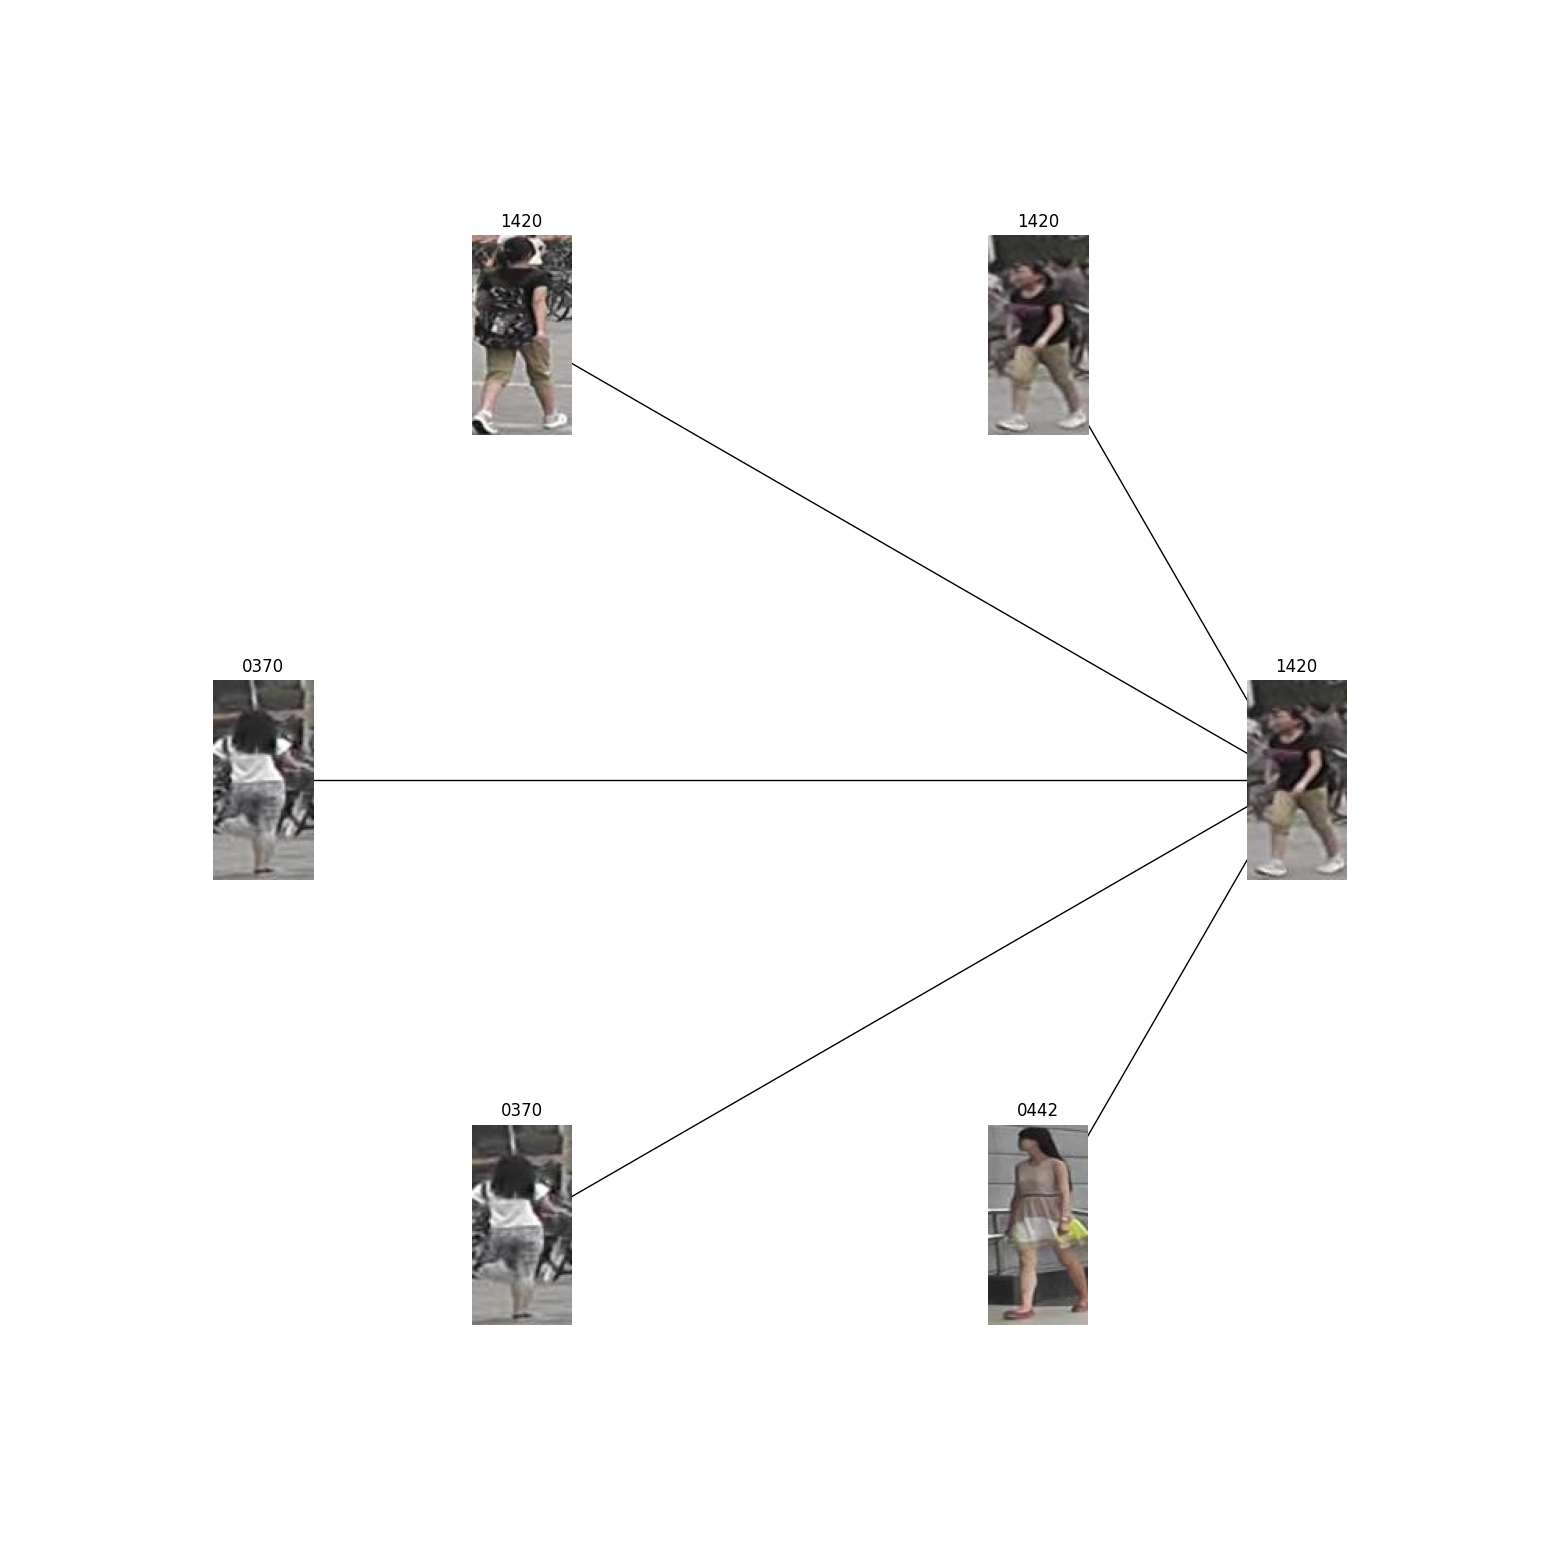

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, Data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);